In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import numpy as np
import sympy
import os
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from underworld3.cython.petsc_discretisation import petsc_dm_find_labeled_points_local

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def get_cmap(var):
    vmin = var.min()
    vmax = var.max()
    radio = np.abs((-vmin)/(vmax-vmin))
    colors = [(0, "blue"), (radio, "white"), (1, "red")]
    cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)
    return cmap    

In [3]:
vmin = -1
vmax =  10
radio = np.abs((-vmin)/(vmax-vmin))
colors = [(vmin, "blue"), (0, "white"), (vmax, "red")]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

In [4]:
def plot_mesh(title,mesh,showFig=True):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data() 
    pvmesh.clear_point_data()
    
def plot_mesh_var(title,mesh,var,showVar=False,showFig=True,cmap="coolwarm"):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showVar:
        with mesh.access():
            points = np.zeros((mesh.data.shape[0],3))
            points[:,0] = mesh.data[:,0]
            points[:,1] = mesh.data[:,1]
            point_cloud = pv.PolyData(points)
            point_cloud.point_data["M"] = uw.function.evalf(var, mesh.data, mesh.N)
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap=cmap, edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 3)
    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()
    
def plot_mesh_var2(title,mesh,var,showVar=False,showFig=True,cmap="coolwarm"):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showVar:
        with mesh.access():
            points = np.zeros((mesh.data.shape[0],3))
            points[:,0] = mesh.data[:,0]
            points[:,1] = mesh.data[:,1]
            point_cloud = pv.PolyData(points)
            point_cloud.point_data["M"] = var
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap=cmap, edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 3)
    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()
    
def plot_mesh_vel(title,mesh,var,cmap,vel,v_coods,v_mag,showVar=False,showFig=True,showVel=False):
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [500, 500]
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True
    pv.global_theme.show_edges = True
    pv.global_theme.axes.show = True

    mesh.vtk("tmp_box_mesh.vtk")
    pvmesh = pv.read("tmp_box_mesh.vtk")
    pl = pv.Plotter()
    pl.add_mesh(pvmesh,'Black', 'wireframe')

    if showVar:
        with mesh.access():
            points = np.zeros((mesh.data.shape[0],3))
            points[:,0] = mesh.data[:,0]
            points[:,1] = mesh.data[:,1]
            point_cloud = pv.PolyData(points)
            point_cloud.point_data["M"] = var
        #pl.add_points(point_cloud, color="red",render_points_as_spheres=False, point_size=3, opacity=0.5)
        pl.add_mesh(point_cloud, cmap=cmap, edge_color="Black", show_edges=False, scalars='M',
                        use_transparency=False, opacity=0.95, point_size= 5)
#         pl.add_mesh(point_cloud, cmap="coolwarm",show_edges=False, scalars='M',
#                         use_transparency=False, opacity=0.95, point_size= 8)

    if showVel:
        
        arrow_loc  = np.zeros([v_coords.shape[0], 3])
        arrow_loc[:, 0] = v_coords[:, 0]
        arrow_loc[:, 1] = v_coords[:, 1]
        arrow_length = np.zeros_like(arrow_loc)
        arrow_length[:, 0] = uw.function.evalf(vel.sym[0], arrow_loc[:, 0:2]).reshape(-1)
        arrow_length[:, 1] = uw.function.evalf(vel.sym[1], arrow_loc[:, 0:2]).reshape(-1)
        for d in range(3):
            arrow_length[:,d][np.isnan(arrow_length[:,d])] = 0.0
        pl.add_arrows(arrow_loc, arrow_length, mag=v_mag, opacity=1.0,color="black",show_scalar_bar=True, scalar_bar_args={'vertical': True})
        


    pl.add_title(title,font_size=11)
    if showFig:
        pl.show(cpos="xy")
    
    pl.screenshot(outputPath+title+".png",window_size=pv.global_theme.window_size,return_img=False) 
    pvmesh.clear_data()
    pvmesh.clear_point_data()

### Level Set  Method Functions

In [5]:
from scipy.spatial import distance
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
def points_in_polygon(pts,polygon):
    pts = np.asarray(pts,dtype='float32')
    polygon = np.asarray(polygon,dtype='float32')
    contour2 = np.vstack((polygon[1:], polygon[:1]))
    test_diff = contour2-polygon
    mask1 = (pts[:,None] == polygon).all(-1).any(-1)
    m1 = (polygon[:,1] > pts[:,None,1]) != (contour2[:,1] > pts[:,None,1])
    slope = ((pts[:,None,0]-polygon[:,0])*test_diff[:,1])-(test_diff[:,0]*(pts[:,None,1]-polygon[:,1]))
    m2 = slope == 0
    mask2 = (m1 & m2).any(-1)
    m3 = (slope < 0) != (contour2[:,1] < polygon[:,1])
    m4 = m1 & m3
    count = np.count_nonzero(m4,axis=-1)
    mask3 = ~(count%2==0)
    mask = mask1 | mask2 | mask3
    return mask

def init_phi(interface_coords,polygon):
    points = mesh.data
    
    index = uw.kdtree.KDTree(interface_coords)
    index.build_index()
    indices, dist_sqr, found = index.find_closest_point(points)
    phi_values = np.sqrt(dist_sqr)
    
    mask = points_in_polygon(points, polygon)
    phi_values[~mask] = -phi_values[~mask]
    
    return phi_values

def init_tracer(interface_coords,fill_param,dx,dy):
    dh = (3*np.maximum(dx,dy))**2
    
    with interfaceSwarm.access():
        index = uw.kdtree.KDTree(interface_coords)
        index.build_index()

    centroids = mesh._get_mesh_centroids().copy(order='C')
    indices, dist_sqr, found = index.find_closest_point(centroids)
    par_centroids = centroids[dist_sqr<=dh]

    par_coords = np.repeat(par_centroids, fill_param, axis=0)
    num_par = par_centroids.shape[0]*fill_param
    par_coords[:,0] += np.random.rand(num_par)*dx-dx/2
    par_coords[:,1] += np.random.rand(num_par)*dy-dy/2
    
    indices, dist_sqr, found = index.find_closest_point(par_coords)
    par_coords_new = par_coords[dist_sqr<=dh]
    
    tracerSwarm = uw.swarm.Swarm(mesh)
    tracerSwarm.add_particles_with_coordinates(par_coords_new)
    return tracerSwarm

In [6]:
outputPath = 'op_LSM_demo/'
outputPath_fig = "op_fig/" 
    
if uw.mpi.size == 1:
    # delete previous model run
    if os.path.exists(outputPath):
        for i in os.listdir(outputPath):
            os.remove(outputPath+ i)
            
    ### create folder if not run before
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
        
if uw.mpi.size == 1:
    # delete previous model run
    if os.path.exists(outputPath_fig):
        for i in os.listdir(outputPath_fig):
            os.remove(outputPath_fig+ i)
            
    ### create folder if not run before
    if not os.path.exists(outputPath_fig):
        os.makedirs(outputPath_fig)
        
figsize = (6,5)

In [7]:
xmin,xmax = -4,4
ymin,ymax = -4,4

dx = 0.125
dy = 0.125

xres = (xmax-xmin)/dx
yres = (ymax-ymin)/dx

mesh = uw.meshing.StructuredQuadBox(elementRes=(int(xres), int(yres)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax))
botwall = petsc_dm_find_labeled_points_local(mesh.dm,"Bottom")
topwall = petsc_dm_find_labeled_points_local(mesh.dm,"Top")
phi = uw.discretisation.MeshVariable(r"\phi", mesh, 1, degree=1,continuous=True)
phi0 = uw.discretisation.MeshVariable(r"\phi_0", mesh, 1, degree=1,continuous=True)
phi_update = uw.discretisation.MeshVariable(r"\phi_{update}", mesh, 1, degree=1,continuous=True)

xnpoints = int((xmax-xmin)/dx+1)
ynpoints = int((ymax-ymin)/dy+1)
grid_x,grid_y = np.meshgrid(np.linspace(xmin,xmax, xnpoints), np.linspace(ymin, ymax, ynpoints))

# cosine wave
# amplitude = 0.1/2
# offset = ymax/2   # L
# wavelength = 1
# k = 2.0 * np.pi / wavelength
# npoints = 100
# x0 = np.linspace(xmin,xmax,npoints)
# y0 = offset + amplitude * np.cos(k * x0)
# interface_coords = np.ascontiguousarray(np.array([x0,y0]).T)
# polygon = np.append(interface_coords,interface_coords[0,:])


## cicle
radius = (xmax-xmin)/4
centre = [0,0]
num_points = 101
angles = np.linspace(0, 2 * np.pi, num_points)
x0 = radius * np.cos(angles)+centre[0]
y0 = radius * np.sin(angles)+centre[1]
interface_coords = np.ascontiguousarray(np.array([x0,y0]).T)
polygon = np.vstack((interface_coords,interface_coords[0,:]))

interfaceSwarm = uw.swarm.Swarm(mesh)
interfaceSwarm.add_particles_with_coordinates(interface_coords)

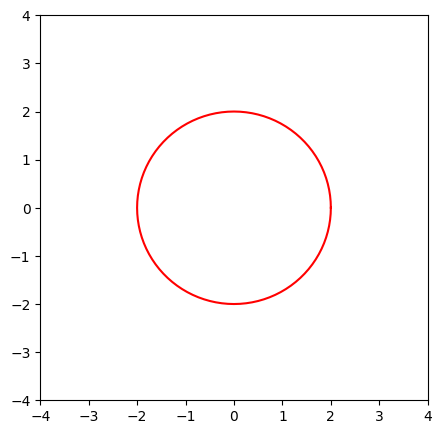

In [8]:
fig, ax1 = plt.subplots(nrows=1, figsize=(5,5))
ax1.plot(*polygon.T, color="red")
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])
plt.show()

In [9]:
phi_values = init_phi(interface_coords,polygon)
with mesh.access(phi):
    phi.data[:,0] = phi_values

with mesh.access(phi0):
    phi0.data[:,0] = phi_values

#fill_param = 4
#tracerSwarm = init_tracer(fill_param,dx,dy)
# with tracerSwarm.access():
#     par_coords = tracerSwarm.data

In [10]:
# from matplotlib.colors import ListedColormap
# with mesh.access(phi):
#     var = phi.data

# vmin = var.min()
# vmax = var.max()
# radio = np.abs((-vmin)/(vmax-vmin))
# colors = [(0, "blue"), (radio, "white"), (1, "red")]
# cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)
# print(vmax,vmin)

# plot_mesh_var("phi_init",mesh,phi.sym[0],showVar=True,showFig=True,cmap=cmap)

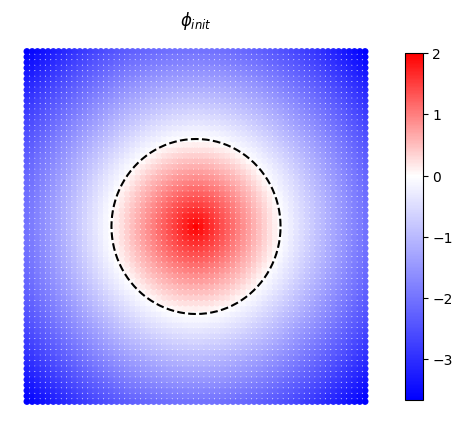

In [11]:
coords = mesh.data

with mesh.access(phi):
    var = phi.data
   
cmap = get_cmap(var)     
fname = f'Fig_phi_init'
var_name = r'$\phi_{init}$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
#ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
#ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

In [12]:
phi_grad_sym = mesh.vector.gradient(phi.sym)
phi_mag_sym = sympy.sqrt(phi_grad_sym[0]**2+phi_grad_sym[1]**2)

phi_mag = uw.discretisation.MeshVariable(r"|\nabla\phi|",mesh,1, degree=1)
phi_mag_calc = uw.systems.Projection(mesh, phi_mag)
phi_mag_calc.uw_function = phi_mag_sym
phi_mag_calc.smoothing = 1.0e-3
phi_mag_calc.petsc_options.delValue("ksp_monitor")

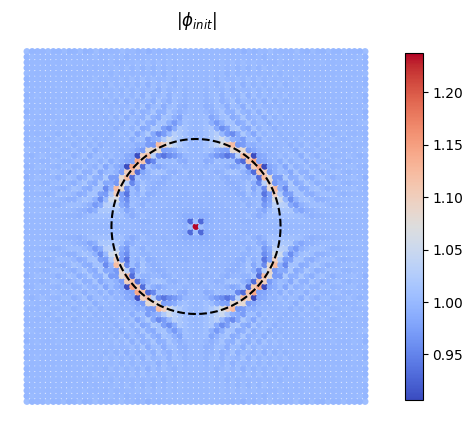

In [13]:
phi_mag_calc.solve()
with mesh.access(phi_mag):
    var = phi_mag.data
cmap = "coolwarm"    
fname = f'Fig_phi_mag_init'
var_name = r'$|\phi_{init}|$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
#ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
#ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

In [14]:
def advec_interface(V_fn,delta_t,data):
    v_at_Vpts = np.zeros_like(data)
    for d in range(mesh.dim):
        v_at_Vpts[:, d] = uw.function.evalf(V_fn[d],data).reshape(-1)
        v_at_Vpts[:,d][np.isnan(v_at_Vpts[:,d])] = 0.0
    new_coords = data[...].copy() + delta_t * v_at_Vpts
    return new_coords



vdegree,pdegree = 1,0
pcont = False

v = uw.discretisation.MeshVariable("V", mesh, mesh.dim, degree=vdegree,continuous=True)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=pdegree,continuous=pcont)

In [15]:
#case 1: vy=1,vx=0
vel = 1
with mesh.access(v):
    v.data[...]=[0,vel]
    
#case 2: vx=-x/2,vy=-y/2
# v.sym[0] = mesh.N.x/2
# v.sym[1] = mesh.N.y/2

#case 4: vy=1,vx=1
# vel = 1
# with mesh.access(v):
#     v.data[...]=[vel,vel]
    


dt = 1
interface_coords_new = advec_interface(v.sym,dt,interface_coords)
polygon_new = np.vstack((interface_coords_new,interface_coords_new[0,:]))
x1 = interface_coords_new[:,0]
y1 = interface_coords_new[:,1]

# case 3: get from stokes equation
# step = 0
# stokes.solve(zero_init_guess=False)
# dt_solver = stokes.estimate_dt()
# print(dt_solver)


# ND_gravity = 1.0
# density1 = 100.0
# density2 = 0.0

# visc1 =  100.0
# visc2 =  1.0

# alphah = 1*dy
# def material_parameter_fn(c1,c2,alphah):
#     return sympy.Piecewise((c1,phi.sym[0] <= -alphah),
#                            (c2,phi.sym[0] > alphah),
#                            ((c2-c1)*phi.sym[0]/alphah/2.+(c1+c2)/2, True))

# visc_fn = sympy.Piecewise((visc2,phi.sym[0] > 0.0),(visc1, True))
# density_fn = sympy.Piecewise((density2,phi.sym[0] > 0.0),(density1, True))  


# # ND_gravity = 1.0
# # visc_fn = 1.0
# # density_fn = 0.

# stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
# stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
# stokes.bodyforce = sympy.Matrix([0, -1 * ND_gravity * density_fn])
# stokes.constitutive_model.Parameters.shear_viscosity_0 = visc_fn
# stokes.saddle_preconditioner = 1.0 / stokes.constitutive_model.Parameters.shear_viscosity_0
# stokes.add_dirichlet_bc((0.0,0.0), "Left", (0,))
# stokes.add_dirichlet_bc((0.0,0.0), "Right", (0,))
# stokes.add_dirichlet_bc((0.0,0.0), "Bottom", (1,))
# stokes.add_dirichlet_bc((0.0,0.0), "Top", (1,))

# if uw.mpi.size == 1:
#     stokes.petsc_options['pc_type'] = 'lu'

# stokes.tolerance = 1.0e-6
# stokes.petsc_options["ksp_rtol"] = 1.0e-6
# stokes.petsc_options["ksp_atol"] = 1.0e-6

# stokes.solve(zero_init_guess=False)
# dt = 1
# interface_coords_new = advec_interface(v.sym,dt,interface_coords)
# polygon_new = np.vstack((interface_coords_new,interface_coords_new[0,:]))
# x1 = interface_coords_new[:,0]
# y1 = interface_coords_new[:,1]

In [16]:
# radius = (xmax-xmin)/4
# num_points = 25
# angles = np.linspace(0, 2 * np.pi, num_points)
# x1_ = radius * np.cos(angles)
# y1_ = radius * np.sin(angles)

# radius = (xmax-xmin)/2
# angles = np.linspace(0, 2 * np.pi, num_points)
# x2_ = radius * np.cos(angles)
# y2_ = radius * np.sin(angles)

# x = np.append(x1_, x2_)
# y = np.append(y1_, y2_)
# v_coords = np.ascontiguousarray(np.array([x,y]).T)

# with mesh.access(phi):
#     phi_data=phi.data
# v_mag = 0.5
# plot_mesh_vel("velfield_init",mesh,phi_data,cmap,v,v_coords,v_mag,True,True,True)

In [17]:
phi_values_new = init_phi(interface_coords_new,polygon_new)
with mesh.access(phi_update):
    phi_update.data[:,0] = phi_values_new

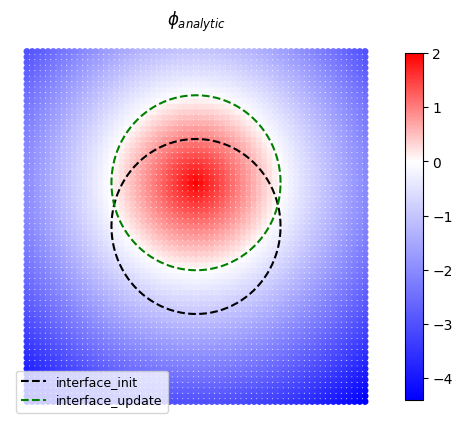

In [18]:
with mesh.access(phi_update):
    var = phi_update.data
cmap = get_cmap(var)     
fname = f'Fig_phi_analytic'
var_name = r'$\phi_{analytic}$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

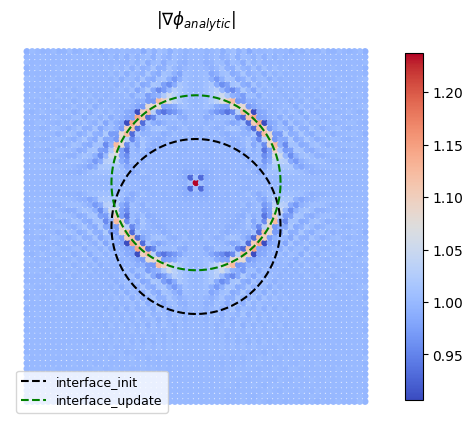

In [19]:
phi_grad_sym = mesh.vector.gradient(phi_update.sym)
phi_mag_sym = sympy.sqrt(phi_grad_sym[0]**2+phi_grad_sym[1]**2)
phi_mag_analytic = uw.discretisation.MeshVariable(r"|\nabla\phi_{analytic}|",mesh,1, degree=1)
phi_mag_analytic_calc = uw.systems.Projection(mesh, phi_mag_analytic)
phi_mag_analytic_calc.uw_function = phi_mag_sym
phi_mag_analytic_calc.smoothing = 1.0e-3
phi_mag_analytic_calc.petsc_options.delValue("ksp_monitor")

phi_mag_analytic_calc.solve()

with mesh.access(phi_mag_analytic):
    var = phi_mag_analytic.data
cmap = "coolwarm"     
fname = f'Fig_phi_mag_analytic'
var_name =r'$|\nabla\phi_{analytic}|$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

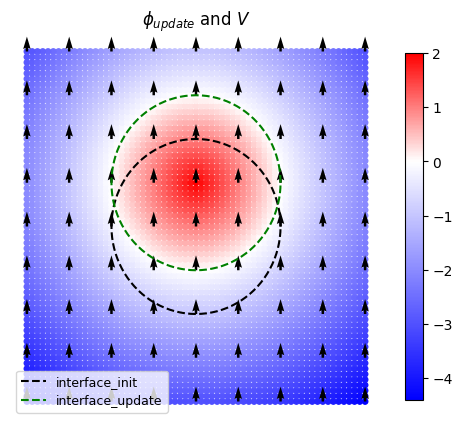

In [20]:
skip = 8
xarrow = grid_x[::skip,::skip]
yarrow = grid_y[::skip,::skip]
xyarrow =np.vstack((xarrow.flatten(),yarrow.flatten())).T
vxarrow = uw.function.evalf(v.sym[0],xyarrow)
vxarrow = vxarrow.reshape(grid_x[::skip,::skip].shape)
vyarrow = uw.function.evalf(v.sym[1],xyarrow)
vyarrow = vyarrow.reshape(grid_x[::skip,::skip].shape)

with mesh.access(phi_update):
    var = phi_update.data
cmap = get_cmap(var)     
fname = f'Fig_phi_update_vel'
var_name = r'$\phi_{update}$ and $V$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
plt.quiver(xarrow, yarrow, vxarrow, vyarrow, scale=25, color='k',zorder=2)
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

## LSM advection and reinit 

In [20]:
import sympy
from sympy import sympify
import numpy as np

from typing import Optional, Callable, Union

import underworld3 as uw
from underworld3.systems import SNES_Scalar, SNES_Vector, SNES_Stokes_SaddlePt
from underworld3 import VarType
import underworld3.timing as timing
from underworld3.utilities._api_tools import uw_object

from ddt import SemiLagrangian as SemiLagrangian_DDt
from ddt import Lagrangian as Lagrangian_DDt

# from .ddt import SemiLagrangian as SemiLagrangian_DDt
# from .ddt import Lagrangian as Lagrangian_DDt


# from underworld3.systems.ddt import SemiLagrangian as SemiLagrangian_DDt
# from underworld3.systems.ddt import Lagrangian as Lagrangian_DDt


#################################################
# Characteristics-based advection-diffusion
# solver based on SNES_Poisson and swarm-to-nodes
#
# Note that the solve() method has the swarm
# handler.
#################################################


class SNES_Advection(SNES_Scalar):
    r"""
    This class provides a solver for the scalar Advection-Diffusion equation using the characteristics based Semi-Lagrange Crank-Nicholson method
    which is described in Spiegelman & Katz, (2006).

    $$
    \color{Green}{\underbrace{ \Bigl[ \frac{\partial u}{\partial t} - 
    \left( \mathbf{v} \cdot \nabla \right) u \Bigr]}_{\dot{\mathbf{f}}}}=
    \color{Maroon}{\underbrace{\Bigl[ f \Bigl] }_{\mathbf{f}}}
    $$

    The term $\dot{\mathbf{f}}$ involves upstream sampling to find the value $u^*$ which represents the value of $u$ at
    the points which later arrive at the nodal points of the mesh. This is achieved using a "hidden"
    swarm variable which is advected backwards from the nodal points automatically during the `solve` phase.

    ## Properties

      - The unknown is $u$.

      - The velocity field is $\mathbf{v}$ and is provided as a `sympy` function to allow operations such as time-averaging to be
        calculated in situ (e.g. `V_Field = v_solution.sym`) **NOTE: no it's not. Currently it is a MeshVariable** this is the desired behaviour though.

      - Volumetric sources of $u$ are specified using the $f$ property and can be any valid combination of `sympy` functions of position and
        `meshVariable` or `swarmVariable` types.

      - The `theta` property sets $\theta$, the parameter that tunes between backward Euler $\theta=1$, forward Euler $\theta=0$ and
        Crank-Nicholson $\theta=1/2$. The default is to use the Crank-Nicholson value.

    ## Notes

      - The solver requires relatively high order shape functions to accurately interpolate the history terms.
        Spiegelman & Katz recommend cubic or higher degree for $u$ but this is not checked.

    ## Reference

    Spiegelman, M., & Katz, R. F. (2006). A semi-Lagrangian Crank-Nicolson algorithm for the numerical solution
    of advection-diffusion problems. Geochemistry, Geophysics, Geosystems, 7(4). https://doi.org/10.1029/2005GC001073

    """
    @timing.routine_timer_decorator
    def __init__(
        self,
        mesh: uw.discretisation.Mesh,
        u_Field: uw.discretisation.MeshVariable,
        V_fn: Union[
            uw.discretisation.MeshVariable, sympy.Basic
        ],  # Should be a sympy function
        order: int = 1,
        solver_name: str = "",
        restore_points_func: Callable = None,
        verbose=False,
    ):
        ## Parent class will set up default values etc
        super().__init__(
            mesh,
            u_Field,
            None,
            None,
            u_Field.degree,
            solver_name,
            verbose,
        )

        if solver_name == "":
            solver_name = "Adv_slcn_{}_".format(self.instance_number)

        if isinstance(V_fn, uw.discretisation._MeshVariable):
            self._V_fn = V_fn.sym
        else:
            self._V_fn = V_fn

        # default values for properties
        self.f = sympy.Matrix.zeros(1, 1)

        self._constitutive_model = uw.constitutive_models.Constitutive_Model(self.Unknowns)

        # These are unique to the advection solver
        self.delta_t = 0.0
        self.is_setup = False

        self.restore_points_to_domain_func = restore_points_func
        self._setup_problem_description = self.adv_slcn_problem_description

        ### Setup the history terms

        self.Unknowns.DuDt = SemiLagrangian_DDt(
            self.mesh,
            u_Field.sym,
            self._V_fn,
            vtype=uw.VarType.SCALAR,
            degree=u_Field.degree,
            continuous=u_Field.continuous,
            varsymbol=u_Field.symbol,
            verbose=verbose,
            bcs=self.essential_bcs,
            order=order,
            smoothing=0.0,
        )

        return

    def adv_slcn_problem_description(self):
        # f0 residual term
        self._f0 = self.F0 - self.f + self.DuDt.bdf() / self.delta_t

        # f1 residual term
        #self._f1 = self.F1 + self.DFDt.adams_moulton_flux()
        self._f1 = self.F1  

        return

    @property
    def f(self):
        return self._f

    @f.setter
    def f(self, value):
        self.is_setup = False
        self._f = sympy.Matrix((value,))

    @property
    def V_fn(self):
        return self._V_fn

    @property
    def delta_t(self):
        return self._delta_t

    @delta_t.setter
    def delta_t(self, value):
        self.is_setup = False
        self._delta_t = sympify(value)

    @timing.routine_timer_decorator
    def solve(
        self,
        zero_init_guess: bool = True,
        timestep: float = None,
        _force_setup: bool = False,
        verbose=False,
    ):
        """
        Generates solution to constructed system.

        Params
        ------
        zero_init_guess:
            If `True`, a zero initial guess will be used for the
            system solution. Otherwise, the current values of `self.u` will be used.
        """

        if timestep is not None and timestep != self.delta_t:
            self.delta_t = timestep  # this will force an initialisation because the functions need to be updated

        if _force_setup:
            self.is_setup = False

#         if not self.constitutive_model._solver_is_setup:
#             self.is_setup = False
#             self.DFDt.psi_fn = self.constitutive_model.flux.T

        if not self.is_setup:
            self._setup_pointwise_functions(verbose)
            self._setup_discretisation(verbose)
            #self._setup_solver(verbose)

        # super().solve(zero_init_guess, _force_setup)

        self.DuDt.update_pre_solve(timestep, verbose=verbose)
        #self.DFDt.update_pre_solve(timestep, verbose=verbose)

        super().solve(zero_init_guess, _force_setup)

        self.DuDt.update_post_solve(timestep, verbose=verbose)
        #self.DFDt.update_post_solve(timestep, verbose=verbose)

        self.is_setup = True
        self.constitutive_model._solver_is_setup = True

        return

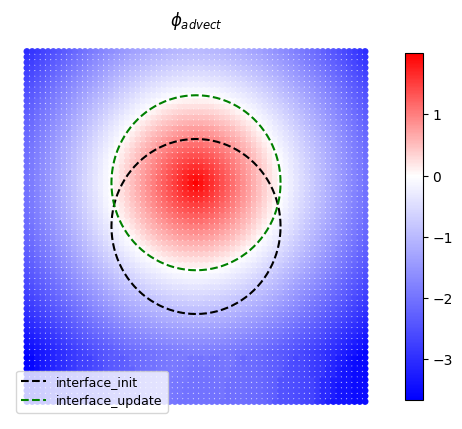

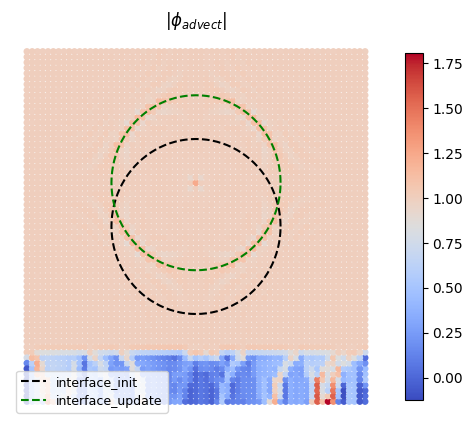

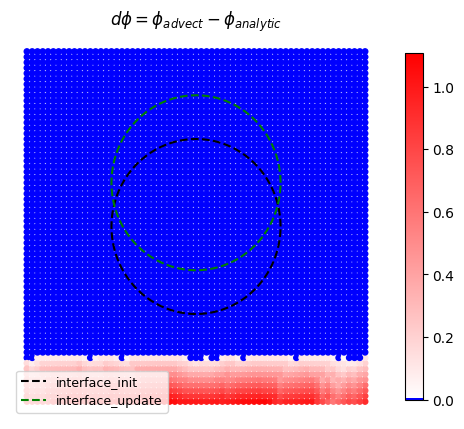

In [21]:
adv_phi = SNES_Advection(mesh, u_Field=phi, V_fn=v, solver_name="adv_phi")
adv_phi.F1 = sympy.Matrix.zeros(1,mesh.dim)
adv_phi.theta = 0.5
adv_phi.tolerance=1.0e-3

adv_phi.solve(timestep=dt,zero_init_guess=False)


with mesh.access(phi):
    var = phi.data
cmap = get_cmap(var)     
fname = f'Fig_phi_update_advect'
var_name = r'$\phi_{advect}$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()


phi_mag_calc.solve()
with mesh.access(phi_mag):
    var = phi_mag.data
cmap = "coolwarm"     
fname = f'Fig_phi_mag_advect'
var_name = r'$|\phi_{advect}|$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()


with mesh.access(phi):
    var0 = phi.data
with mesh.access(phi_update):
    var1 = phi_update.data
var = var0 -var1
cmap = get_cmap(var)     
fname = f'Fig_dphi_advect_minus_analytic'
var_name = r'$ d \phi=\phi_{advect}-\phi_{analytic} $'


f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

In [23]:
# ### update by advect_diff


# phi_values = init_phi(interface_coords,polygon)
# with mesh.access(phi):
#     phi.data[:,0] = phi_values

# ## update phi
# advdiff_phi = uw.systems.AdvDiffusion(mesh, u_Field=phi, V_fn=v, solver_name="advdiff_phi")
# advdiff_phi.constitutive_model = uw.constitutive_models.DiffusionModel
# advdiff_phi.constitutive_model.Parameters.diffusivity= 0.
# advdiff_phi.theta = 0.5
# advdiff_phi.tolerance=1.0e-3
# # adv_diff.add_dirichlet_bc(0.0, "Lower")
# # adv_diff.add_dirichlet_bc(0.0, "Upper")
# advdiff_phi.solve(timestep=dt,zero_init_guess=False)


# with mesh.access(phi):
#     var = phi.data
# cmap = get_cmap(var)     
# fname = f'Fig_phi_update_advectdiff'
# var_name = r'$\phi_{advectdiff}$'

# f, ax1 = plt.subplots(1, 1, figsize=figsize)
# ax1.set_title(var_name)
# #plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
# scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
# cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
# ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
# ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
# ax1.legend(loc = 'lower left',prop = {'size':9})
# ax1.axis('off')
# plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
# plt.show()


# phi_mag_calc.solve()
# with mesh.access(phi_mag):
#     var = phi_mag.data
# cmap = "coolwarm"     
# fname = f'Fig_phi_mag_advecdifft'
# var_name = r'$|\phi_{advectdiff}|$'

# f, ax1 = plt.subplots(1, 1, figsize=figsize)
# ax1.set_title(var_name)
# #plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
# scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
# cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
# ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
# ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
# ax1.legend(loc = 'lower left',prop = {'size':9})
# ax1.axis('off')
# plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
# plt.show()


# with mesh.access(phi):
#     var0 = phi.data
# with mesh.access(phi_update):
#     var1 = phi_update.data
# var = var0 -var1
# cmap = get_cmap(var)     
# fname = f'Fig_dphi_advectdiff_minus_analytic'
# var_name = r'$ d \phi=\phi_{advectdiff}-\phi_{analytic} $'


# f, ax1 = plt.subplots(1, 1, figsize=figsize)
# ax1.set_title(var_name)
# #plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
# scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
# cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
# ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
# ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
# ax1.legend(loc = 'lower left',prop = {'size':9})
# ax1.axis('off')
# plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
# plt.show()

### Reinit

In [23]:
import sympy
from sympy import sympify
import numpy as np
from typing import Optional, Callable, Union
import underworld3 as uw
from underworld3 import VarType
import underworld3.timing as timing
from underworld3.utilities._api_tools import uw_object


class RK2(uw_object):
    def __init__(
            self,
            mesh: uw.discretisation.Mesh,
            psi, 
            varsymbol: Optional[str] = r"u",
            verbose: Optional[bool] = False,
            varepsilon = sympify(1e-3),
            delta_t = sympify(1e-4),
            bcs=[],
            order=1,
            smoothing=0.0,
            under_relaxation=0.0,
            bc_mask_fn=1,
        ):
            super().__init__()

            self.mesh = mesh
            self.bcs = bcs
            self.verbose = verbose
            self._varepsilon = varepsilon
            self._delta_t = delta_t
            
            self.psi = psi
            self._psi_fn = psi.sym
            self.order = order

            self.psi_star = []
            self._smoothing = smoothing

            for i in range(order+1):
                self.psi_star.append(
                    uw.discretisation.MeshVariable(
                        f"psi_star_sl_{self.instance_number}_{i}",
                        self.mesh,
                        vtype=uw.VarType.SCALAR,
                        degree=psi.degree,
                        continuous=psi.continuous,
                        varsymbol=rf"{varsymbol}^{(i+1)}",))
                   
    def update_post_solve(self,dt: float,verbose: Optional[bool] = False):
        phi_fn =  self._psi_fn   
        u_grad = self.mesh.vector.gradient(phi_fn)
        u_mag_sym = sympy.sqrt(u_grad[0]**2+u_grad[1]**2)
        weighting_function = phi_fn/ sympy.sqrt(phi_fn[0]**2+self._varepsilon**2)
        psi1_fn = (1-u_mag_sym) * weighting_function*self._delta_t*sympify(0.5)+phi_fn
        self._psi_star1_projection_solver = uw.systems.solvers.SNES_Projection(
            self.mesh, self.psi_star[0], verbose=False)
        self._psi_star1_projection_solver.uw_function = psi1_fn
        #self._psi_star1_projection_solver.bcs = bcs
        self._psi_star1_projection_solver.smoothing = self._smoothing
        self._psi_star1_projection_solver.solve()


        phi_fn =  self.psi_star[0].sym  
        u_grad = self.mesh.vector.gradient(phi_fn)
        u_mag_sym = sympy.sqrt(u_grad[0]**2+u_grad[1]**2)
        #weighting_function = phi_fn/ sympy.sqrt(phi_fn[0]**2+self._varepsilon**2)
        psi2_fn = (1-u_mag_sym) * weighting_function*self._delta_t+self._psi_fn

        self._psi_star2_projection_solver = uw.systems.solvers.SNES_Projection(
            self.mesh, self.psi_star[1], verbose=False)
        self._psi_star2_projection_solver.uw_function = psi2_fn
        #self._psi_star2_projection_solver.bcs = bcs
        self._psi_star2_projection_solver.smoothing = self._smoothing
        self._psi_star2_projection_solver.solve()
                                
        with mesh.access(self.psi):
            self.psi.data[...] = self.psi_star[1].data[...]
        return
    
    def rkf(self, order=None):
        if order is None:
            order = self.order

        with sympy.core.evaluate(False):
            if order == 0:  # special case - no history term (catch )
                bdf0 = sympy.simpify[0]

            if order == 1:
                bdf0 = self.psi_star[1].sym - self._psi_fn

        return bdf0

In [70]:
# import sympy
# from sympy import sympify
# import numpy as np

# from typing import Optional, Callable, Union

# import underworld3 as uw
# from underworld3.systems import SNES_Scalar, SNES_Vector, SNES_Stokes_SaddlePt
# from underworld3 import VarType
# import underworld3.timing as timing
# from underworld3.utilities._api_tools import uw_object

# from ddt import SemiLagrangian as SemiLagrangian_DDt
# from ddt import Lagrangian as Lagrangian_DDt

# # from .ddt import SemiLagrangian as SemiLagrangian_DDt
# # from .ddt import Lagrangian as Lagrangian_DDt


# # from underworld3.systems.ddt import SemiLagrangian as SemiLagrangian_DDt
# # from underworld3.systems.ddt import Lagrangian as Lagrangian_DDt


# #################################################
# # Characteristics-based advection-diffusion
# # solver based on SNES_Poisson and swarm-to-nodes
# #
# # Note that the solve() method has the swarm
# # handler.
# #################################################


# class SNES_HJ(SNES_Scalar):
#     @timing.routine_timer_decorator
#     def __init__(
#         self,
#         mesh: uw.discretisation.Mesh,
#         u_Field: uw.discretisation.MeshVariable,
#         varepsilon = 1e-3,
#         order: int = 1,
#         solver_name: str = "",
#         restore_points_func: Callable = None,
#         verbose=False,
#     ):
#         ## Parent class will set up default values etc
#         super().__init__(
#             mesh,
#             u_Field,
#             None,
#             None,
#             u_Field.degree,
#             solver_name,
#             verbose,
#         )

#         if solver_name == "":
#             solver_name = "HJ_{}_".format(self.instance_number)
            
#         self._constitutive_model = uw.constitutive_models.Constitutive_Model(self.Unknowns)

#         # These are unique to the advection solver
#         self._varepsilon = sympify(varepsilon)
#         self._delta_t = sympify(0.1*varepsilon)
#         self.is_setup = False

#         self.restore_points_to_domain_func = restore_points_func
#         self._setup_problem_description = self.adv_hj_problem_description

#         ### Setup the history terms

#         self.dudt = RK2(self.mesh,u_Field,varepsilon=self._varepsilon,delta_t =self._delta_t,order=1)

#         return

#     def adv_hj_problem_description(self):
#         # f0 residual term
#         self._f0 = self.F0 + self.dudt.rkf() / self.delta_t

#         # f1 residual term
#         #self._f1 = self.F1 + self.DFDt.adams_moulton_flux()
#         self._f1 = self.F1  

#         return

#     @property
#     def delta_t(self):
#         return self._delta_t

#     @delta_t.setter
#     def delta_t(self, value):
#         self.is_setup = False
#         self._delta_t = sympify(value)

#     @timing.routine_timer_decorator
#     def solve(
#         self,
#         zero_init_guess: bool = True,
#         timestep: float = None,
#         _force_setup: bool = False,
#         verbose=False,
#     ):
#         """
#         Generates solution to constructed system.

#         Params
#         ------
#         zero_init_guess:
#             If `True`, a zero initial guess will be used for the
#             system solution. Otherwise, the current values of `self.u` will be used.
#         """

#         if timestep is not None and timestep != self.delta_t:
#             self.delta_t = timestep  # this will force an initialisation because the functions need to be updated

#         if _force_setup:
#             self.is_setup = False

# #         if not self.constitutive_model._solver_is_setup:
# #             self.is_setup = False
# #             self.DFDt.psi_fn = self.constitutive_model.flux.T

#         if not self.is_setup:
#             self._setup_pointwise_functions(verbose)
#             self._setup_discretisation(verbose)
#             #self._setup_solver(verbose)

#         # super().solve(zero_init_guess, _force_setup)

#         #self.DuDt.update_pre_solve(timestep, verbose=verbose)
#         #self.DFDt.update_pre_solve(timestep, verbose=verbose)

#         super().solve(zero_init_guess, _force_setup)

#         self.dudt.update_post_solve(timestep, verbose=verbose)
#         #self.DFDt.update_post_solve(timestep, verbose=verbose)

#         self.is_setup = True
#         self.constitutive_model._solver_is_setup = True

#         return
    
#     @property
#     def varepsilon(self):
#         return self._varepsilon
    
#     @varepsilon.setter
#     def varepsilon(self, varepsilon_factor):
#         self.is_setup = False
#         self._varepsilon = sympify(varepsilon_factor)
#         self._delta_t = sympify(0.1*varepsilon_factor)

In [28]:
phi_values = init_phi(interface_coords,polygon)
with mesh.access(phi):
    phi.data[:,0] = phi_values
adv_phi.solve(timestep=dt,zero_init_guess=False)


reinit = RK2(mesh=mesh,psi=phi,varepsilon=sympify(dx),delta_t=sympify(dx*0.1)) 

#reinit.update_post_solve(dt)
NEvolove= 60
for e in range(0,NEvolove):
    reinit.update_post_solve(dt)
    with mesh.access(phi):
            phi.data[...] = reinit.psi.data[...]

Variable with name psi_star_sl_1_0 already exists on the mesh - Skipping.


In [ ]:
# reinit = RK2(mesh=mesh,psi=phi,varepsilon=dx) 

# NEvolove=50
# for e in range(0,NEvolove):
#     reinit.solve()
#     with mesh.access(phi):
#             phi.data[...] = reinit.psi.data[...]

In [ ]:
# reinit_phi = SNES_HJ(mesh, u_Field=phi,varepsilon=dx, solver_name="reinit_phi")
# reinit_phi.tolerance = 1e-3
# reinit_phi.solve(dt)

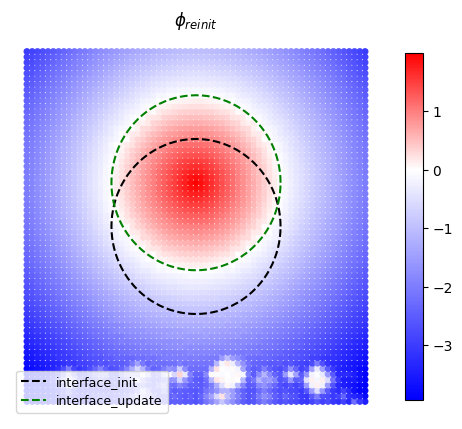

Variable with name |\nabla\phi_{updateplus}| already exists on the mesh - Skipping.


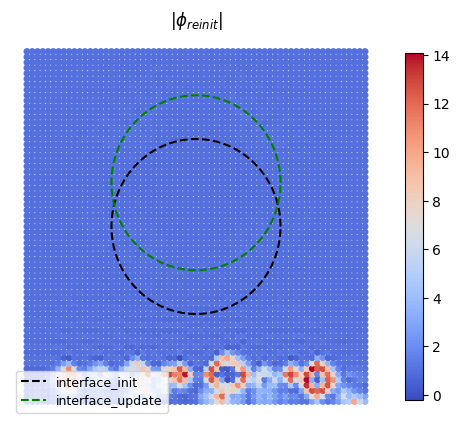

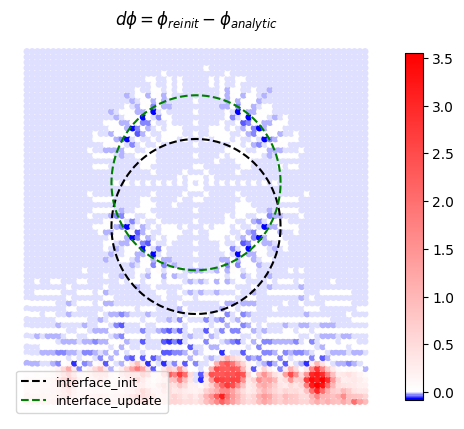

In [30]:
with mesh.access(phi):
    var = phi.data
cmap = get_cmap(var)     
fname = f'Fig_phi_reinit_RK2'
var_name = r'$\phi_{reinit}$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()


u = phi.sym
grad_sym = mesh.vector.gradient(u)
mag_sym = sympy.sqrt(grad_sym[0]**2+grad_sym[1]**2)

mag = uw.discretisation.MeshVariable(r"|\nabla\phi_{updateplus}|",mesh,1, degree=1)
mag_calc = uw.systems.Projection(mesh,mag)
mag_calc.uw_function = mag_sym
mag_calc.smoothing = 1.0e-3
mag_calc.petsc_options.delValue("ksp_monitor")
mag_calc.solve()

mag_calc.solve()
with mesh.access(mag):
    var = mag.data
cmap = "coolwarm"    
fname = f'Fig_phi_mag_reinit_RK2'
var_name = r'$|\phi_{reinit}|$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()


with mesh.access(phi):
    var0 = phi.data
with mesh.access(phi_update):
    var1 = phi_update.data
var = var0 -var1
cmap = get_cmap(var)  
fname = f'Fig_dphi_reinit_RK2_minus_analytic'
var_name = r'$ d \phi=\phi_{reinit}-\phi_{analytic} $'


f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

### Reinit with $sign(\phi)|\nabla\phi-1|dt+\phi$  Forward Euler

Variable with name sign(\phi)|\nabla\phi-1|+phi already exists on the mesh - Skipping.
Variable with name |\nabla\phi_{updateplus}| already exists on the mesh - Skipping.


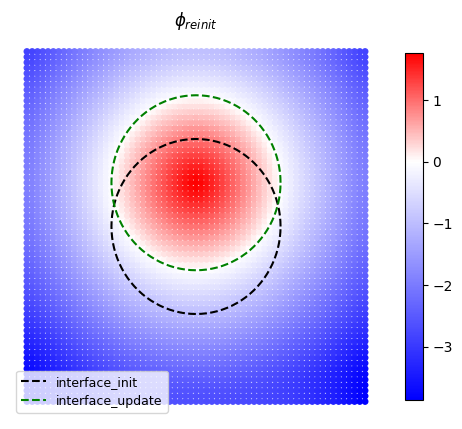

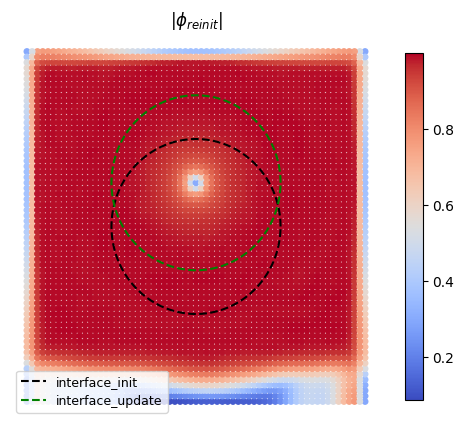

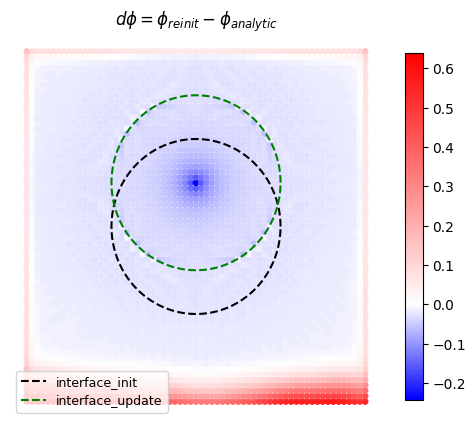

In [31]:
phi_values = init_phi(interface_coords,polygon)
with mesh.access(phi):
    phi.data[:,0] = phi_values
adv_phi.solve(timestep=dt,zero_init_guess=False) 

with mesh.access(phi):
    phi_data_advect = phi.data


u = phi
varepsilon = dx 
_delta_t =  varepsilon*0.1

u_grad    = mesh.vector.gradient(u.sym)
u_mag_sym = sympy.sqrt(u_grad[0]**2+u_grad[1]**2)
weighting_function = u.sym / sympy.sqrt(u.sym[0]**2+varepsilon**2)
reinitphi_sym = (1-u_mag_sym)* weighting_function *_delta_t + u.sym

reinitphi = uw.discretisation.MeshVariable(r"sign(\phi)|\nabla\phi-1|+phi",mesh,1, degree=1)
reinitphi_calc = uw.systems.Projection(mesh, reinitphi)
reinitphi_calc.uw_function = reinitphi_sym
reinitphi_calc.smoothing = 1.0e-3
reinitphi_calc.petsc_options.delValue("ksp_monitor")

NEvolove=60

for e in range(0,NEvolove):
        reinitphi_calc.solve()
        with mesh.access(phi):
            phi.data[...] = reinitphi.data[...]

u = reinitphi.sym
grad_sym = mesh.vector.gradient(u)
mag_sym = sympy.sqrt(grad_sym[0]**2+grad_sym[1]**2)

mag = uw.discretisation.MeshVariable(r"|\nabla\phi_{updateplus}|",mesh,1, degree=1)
mag_calc = uw.systems.Projection(mesh,mag)
mag_calc.uw_function = mag_sym
mag_calc.smoothing = 1.0e-3
mag_calc.petsc_options.delValue("ksp_monitor")
mag_calc.solve()

with mesh.access(reinitphi):
    var = reinitphi.data
cmap = get_cmap(var)     
fname = f'Fig_phi_reinit_euler'
var_name = r'$\phi_{reinit}$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

mag_calc.solve()
with mesh.access(mag):
    var = mag.data
cmap = "coolwarm"    
fname = f'Fig_phi_mag_reinit_euler'
var_name = r'$|\phi_{reinit}|$'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()

with mesh.access(phi):
    var0 = phi.data
with mesh.access(phi_update):
    var1 = phi_update.data
var = var0 -var1
cmap = get_cmap(var)  
fname = f'Fig_dphi_reinit_euler_minus_analytic_euler'
var_name = r'$ d \phi=\phi_{reinit}-\phi_{analytic} $'

f, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title(var_name)
#plot_grid(grid_x,grid_y, ax=ax1,colors='grey')
scatter = ax1.scatter(coords[:,0],coords[:,1],c =var,cmap =cmap,zorder=2,s=15)
cbar = plt.colorbar(scatter, label='',location = "right",shrink=0.9)
ax1.plot(x0,y0,'--k',zorder=2,label=f"interface_init")
ax1.plot(x1,y1,'--g',zorder=2,label=f"interface_update")
ax1.legend(loc = 'lower left',prop = {'size':9})
ax1.axis('off')
plt.savefig(outputPath_fig+fname,dpi=300,bbox_inches='tight')
plt.show()